In [47]:

import json, re, torch, time, math, random, os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader


In [48]:

# Hyperparameters
EMB_DIM = 400
HIDDEN_DIM = 512
BATCH_SIZE = 64
N_LAYERS = 2
LR = 0.0004
RNN_EPOCHS = 50
TRUNCATE_LENGTH = 20
KERNEL_SIZE = 5
# Define device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [49]:

# Paths to Cornell dataset files
lines_path = "movie_lines.txt"
conversations_path = "movie_conversations.txt"
intents_path = "intents.json"

# Preprocess a sentence: lowercase and remove unwanted characters
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    return sentence

def preprocess_cornell(lines_path, conversations_path):
    # Load lines and map them to their IDs
    id2line = {}
    with open(lines_path, encoding='utf-8', errors='ignore') as file:
        for line in file:
            parts = line.strip().split(" +++$+++ ")
            if len(parts) == 5:
                id2line[parts[0]] = parts[4]

    # Load conversations and extract pairs
    pairs = []
    with open(conversations_path, encoding='utf-8', errors='ignore') as file:
        for line in file:
            parts = line.strip().split(" +++$+++ ")
            if len(parts) == 4:
                conv_ids = eval(parts[3])  # List of dialog IDs
                for i in range(len(conv_ids) - 1):
                    # Check if both dialog IDs exist in id2line
                    if conv_ids[i] in id2line and conv_ids[i + 1] in id2line:
                        input_line = id2line[conv_ids[i]]
                        target_line = id2line[conv_ids[i + 1]]
                        pairs.append((preprocess_sentence(input_line), preprocess_sentence(target_line)))
    return pairs


cornell_pairs = preprocess_cornell(lines_path, conversations_path)
sampled_cornell_pairs = cornell_pairs[:1500] 
print(f"Number of valid Cornell pairs: {len(sampled_cornell_pairs)}")


Number of valid Cornell pairs: 1500


In [50]:
# Load intents.json
with open(intents_path, "r") as file:
    intents = json.load(file)

# Combine intents.json data with Cornell pairs
combined_pairs = []
patterns, labels = [], []
for intent in intents['intents']:
    for pattern in intent['patterns']:
        for response in intent['responses']:
            combined_pairs.append((preprocess_sentence(pattern), preprocess_sentence(response)))
            patterns.append(preprocess_sentence(pattern))
            labels.append(intent['tag'])
combined_pairs.extend(sampled_cornell_pairs)
print(f"Total combined pairs: {len(combined_pairs)}")

# Build label mapping for intent classification
label2idx = {label: idx for idx, label in enumerate(set(labels))}
idx2label = {idx: label for label, idx in label2idx.items()}
labels = [label2idx[label] for label in labels]


Total combined pairs: 2028


In [51]:
# Build vocabulary
def build_vocab(pairs, max_vocab_size=7000):
    # Count word frequencies
    words = Counter()
    for input_text, target_text in pairs:
        words.update(input_text.split())
        words.update(target_text.split())
    
    # Select the most common words
    most_common_words = {word for word, _ in words.most_common(max_vocab_size)}

    # Create mappings with <UNK> token for rare words
    word2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
    for word in most_common_words:
        if word not in word2idx:
            word2idx[word] = len(word2idx)
    
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

word2idx, idx2word = build_vocab(combined_pairs)
print(f"Vocabulary size: {len(word2idx)}")

Vocabulary size: 4590


In [52]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(patterns).toarray()
y = np.array(labels)

In [53]:
# Split data for intent classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [54]:
# Define the MLP for intent classification
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the MLP model
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(label2idx)
intent_model = MLP(input_dim, hidden_dim, output_dim)

In [55]:
# Loss and optimizer for MLP
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(intent_model.parameters(), lr=LR)

In [56]:
# Define number of epochs and an optional early stopping patience
EPOCHS = 1000
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    # Initialize train loss
    train_loss = 0

    # Training Phase
    intent_model.train()
    mlp_optimizer.zero_grad()
    outputs = intent_model(X_train)
    loss = mlp_criterion(outputs, y_train)
    loss.backward()
    mlp_optimizer.step()
    train_loss = loss.item()  # Track train loss

    # Validation Phase
    intent_model.eval()
    with torch.no_grad():
        val_outputs = intent_model(X_test)
        val_loss = mlp_criterion(val_outputs, y_test)
        val_predictions = torch.argmax(val_outputs, dim=1)
        val_accuracy = (val_predictions == y_test).float().mean()

    # Logging
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy.item() * 100:.2f}%")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/1000, Train Loss: 3.6405, Val Loss: 3.6381, Val Accuracy: 3.77%
Epoch 2/1000, Train Loss: 3.6365, Val Loss: 3.6353, Val Accuracy: 3.77%
Epoch 3/1000, Train Loss: 3.6325, Val Loss: 3.6324, Val Accuracy: 3.77%
Epoch 4/1000, Train Loss: 3.6285, Val Loss: 3.6296, Val Accuracy: 3.77%
Epoch 5/1000, Train Loss: 3.6245, Val Loss: 3.6268, Val Accuracy: 3.77%
Epoch 6/1000, Train Loss: 3.6205, Val Loss: 3.6239, Val Accuracy: 3.77%
Epoch 7/1000, Train Loss: 3.6165, Val Loss: 3.6211, Val Accuracy: 3.77%
Epoch 8/1000, Train Loss: 3.6125, Val Loss: 3.6182, Val Accuracy: 5.03%
Epoch 9/1000, Train Loss: 3.6085, Val Loss: 3.6154, Val Accuracy: 6.29%
Epoch 10/1000, Train Loss: 3.6045, Val Loss: 3.6125, Val Accuracy: 6.29%
Epoch 11/1000, Train Loss: 3.6005, Val Loss: 3.6096, Val Accuracy: 8.18%
Epoch 12/1000, Train Loss: 3.5965, Val Loss: 3.6067, Val Accuracy: 9.43%
Epoch 13/1000, Train Loss: 3.5924, Val Loss: 3.6038, Val Accuracy: 8.81%
Epoch 14/1000, Train Loss: 3.5883, Val Loss: 3.6008, Val Acc

In [57]:
# Evaluate the model for intent classification
intent_model.eval()
outputs = intent_model(X_test)
predictions = torch.argmax(outputs, dim=1)
intent_accuracy = (predictions == y_test).float().mean()
intent_result = intent_accuracy.item() * 100
print(f"Test Accuracy: {intent_result:.2f}%")

# Example Prediction
sample_inputs = ["Hi", "Hello", "Howdy", "Greetings", "What's up?", "Goodbye", "Thanks"]
for sample in sample_inputs:
    sample_vector = vectorizer.transform([sample]).toarray()
    sample_tensor = torch.tensor(sample_vector, dtype=torch.float32)
    output = intent_model(sample_tensor)
    predicted_label = idx2label[torch.argmax(output).item()]
    print(f"Input: {sample}, Predicted Intent: {predicted_label}")

Test Accuracy: 86.16%
Input: Hi, Predicted Intent: greeting
Input: Hello, Predicted Intent: greeting
Input: Howdy, Predicted Intent: greeting
Input: Greetings, Predicted Intent: greeting
Input: What's up?, Predicted Intent: greeting
Input: Goodbye, Predicted Intent: goodbye
Input: Thanks, Predicted Intent: salutaion


In [58]:
# Convert pairs to indices
def convert_to_indices(pairs, word2idx):
    input_indices = [
        [word2idx.get(word, word2idx['<UNK>']) for word in inp.split()] for inp, _ in pairs
    ]
    target_indices = [
        [word2idx.get(word, word2idx['<UNK>']) for word in out.split()] for _, out in pairs
    ]
    return input_indices, target_indices

input_indices, target_indices = convert_to_indices(combined_pairs, word2idx)

# Pad sequences
input_tensors = pad_sequence(
    [torch.tensor(seq[:TRUNCATE_LENGTH]) for seq in input_indices],
    batch_first=True, padding_value=word2idx['<PAD>']
)
target_tensors = pad_sequence(
    [torch.tensor(seq[:TRUNCATE_LENGTH]) for seq in target_indices],
    batch_first=True, padding_value=word2idx['<PAD>']
)

# Create TensorDataset and DataLoader
dataset = TensorDataset(input_tensors, target_tensors)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


print(f"Input tensor shape: {input_tensors.shape}")
print(f"Target tensor shape: {target_tensors.shape}")

Input tensor shape: torch.Size([2028, 20])
Target tensor shape: torch.Size([2028, 20])


In [59]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout=0.3):
        super(RNNEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # Embed input
        encoder_outputs, (hidden, cell) = self.rnn(embedded)  # RNN forward pass
        return encoder_outputs, (hidden, cell)


In [60]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))

    def forward(self, hidden, encoder_outputs):
        batch_size, seq_len, hidden_dim = encoder_outputs.shape

        # Expand hidden to match encoder_outputs
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # (batch_size, seq_len, hidden_dim)

        # Compute energy scores
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch_size, seq_len, hidden_dim)
        attention = torch.sum(self.v * energy, dim=2)  # (batch_size, seq_len)

        # Normalize along sequence length
        return torch.softmax(attention, dim=1)  # (batch_size, seq_len)


In [61]:
class RNNDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout=0.3):
        super(RNNDecoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim + hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, hidden, cell, encoder_outputs):
        trg = trg.unsqueeze(1)  # Ensure trg has shape (batch_size, 1)
        embedded = self.dropout(self.embedding(trg)).squeeze(2)  # Remove extra dimension

        # Compute attention weights and context vector
        attention_weights = self.attention(hidden[-1], encoder_outputs)  # (batch_size, seq_len)
        attention_weights = attention_weights.unsqueeze(1)  # (batch_size, 1, seq_len)

        context = torch.bmm(attention_weights, encoder_outputs)  # (batch_size, 1, hidden_dim)

        # Concatenate embedded input and context vector
        rnn_input = torch.cat((embedded, context), dim=2)  # (batch_size, 1, emb_dim + hidden_dim)

        # Forward pass through RNN
        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))  # (batch_size, 1, hidden_dim)

        # Generate predictions
        predictions = self.fc_out(torch.cat((outputs.squeeze(1), context.squeeze(1)), dim=1))  # (batch_size, output_dim)
        return predictions, hidden, cell


In [62]:
class CNNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, kernel_size, dropout=0.5):
        super(CNNEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.conv = nn.Conv1d(emb_dim, hidden_dim, kernel_size, padding=kernel_size//2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # (batch_size, seq_len, emb_dim)
        embedded = embedded.permute(0, 2, 1)  # (batch_size, emb_dim, seq_len)
        conv_output = self.conv(embedded)  # (batch_size, hidden_dim, seq_len)
        conv_output = conv_output.permute(0, 2, 1)  # Back to (batch_size, seq_len, hidden_dim)
        return conv_output

In [135]:
class CNNDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, kernel_size, dropout=0.5):
        super(CNNDecoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.conv = nn.Conv1d(
            in_channels=emb_dim + hidden_dim,  # Concatenate embedded + encoder output
            out_channels=hidden_dim,
            kernel_size=kernel_size,
            padding=kernel_size // 2  # Ensure output has the same sequence length
        )
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, encoder_output):
        # Fix trg shape
        if trg.dim() == 2:  # Shape: (batch_size, seq_len)
            trg = trg.unsqueeze(2)  # Add channel dimension: (batch_size, seq_len, 1)
        elif trg.dim() == 3 and trg.size(2) != 1:
            trg = trg[:, :, :1]  # Slice to retain only 1 channel

        # Embed the target sequence
        embedded = self.dropout(self.embedding(trg.squeeze(2)))  # (batch_size, seq_len, emb_dim)
        embedded = embedded.permute(0, 2, 1)  # (batch_size, emb_dim, seq_len)

        # Permute encoder_output to match channel dimension
        encoder_output = encoder_output.permute(0, 2, 1)  # (batch_size, hidden_dim, seq_len)

        # Ensure sequence length consistency
        seq_len = max(embedded.size(2), encoder_output.size(2))
        if encoder_output.size(2) < seq_len:
            pad_size = seq_len - encoder_output.size(2)
            encoder_output = torch.cat(
                (encoder_output, torch.zeros(encoder_output.size(0), encoder_output.size(1), pad_size).to(encoder_output.device)),
                dim=2,
            )
        elif embedded.size(2) < seq_len:
            pad_size = seq_len - embedded.size(2)
            embedded = torch.cat(
                (embedded, torch.zeros(embedded.size(0), embedded.size(1), pad_size).to(embedded.device)),
                dim=2,
            )

        # Concatenate along the feature dimension
        combined = torch.cat((embedded, encoder_output), dim=1)  # (batch_size, emb_dim + hidden_dim, seq_len)

        # Apply convolution
        conv_output = torch.tanh(self.conv(combined))  # (batch_size, hidden_dim, seq_len)
        conv_output = conv_output.permute(0, 2, 1)  # Back to (batch_size, seq_len, hidden_dim)

        # Generate predictions
        predictions = self.fc_out(conv_output)  # (batch_size, seq_len, output_dim)
        return predictions


In [136]:
INPUT_DIM = len(word2idx)
OUTPUT_DIM = len(word2idx)

# Models Initialization

# RNN Models
rnn_encoder = RNNEncoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM, N_LAYERS)
rnn_decoder = RNNDecoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM, N_LAYERS)

# CNN Models
cnn_encoder = CNNEncoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM, KERNEL_SIZE)
cnn_decoder = CNNDecoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM, KERNEL_SIZE)

# Move to device
rnn_encoder, rnn_decoder = rnn_encoder.to(device), rnn_decoder.to(device)
cnn_encoder, cnn_decoder = cnn_encoder.to(device), cnn_decoder.to(device)

# Optimizers
rnn_enc_optimizer = optim.Adam(rnn_encoder.parameters(), lr=LR)
rnn_dec_optimizer = optim.Adam(rnn_decoder.parameters(), lr=LR)
cnn_enc_optimizer = optim.Adam(cnn_encoder.parameters(), lr=LR)
cnn_dec_optimizer = optim.Adam(cnn_decoder.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])


In [65]:
def calculate_perplexity(loss):
    return math.exp(loss)

In [66]:
def evaluate_bleu(model, dataset, word2idx, idx2word, max_len=10):
    encoder, decoder = model
    bleu_scores = []

    for input_indices, target_indices in dataset:
        # Convert target indices to words for reference
        reference = [
            [
                idx2word[idx]
                for idx in target_indices
                if idx not in {word2idx['<PAD>'], word2idx['<SOS>'], word2idx['<EOS>']}
            ]
        ]

        # Prepare input tensor
        input_tensor = torch.tensor([input_indices]).to(device)

        if isinstance(encoder, RNNEncoder):
            # RNN Encoder: Get encoder_outputs and hidden states
            encoder_outputs, (hidden, cell) = encoder(input_tensor)

            # Decoder starts with <SOS>
            decoder_input = torch.tensor([[word2idx['<SOS>']]]).to(device)
            output_sentence = []

            for _ in range(max_len):
                outputs, hidden, cell = decoder(decoder_input, hidden, cell, encoder_outputs)
                prediction = outputs.argmax(1)  # Get the next word index
                next_word = idx2word[prediction.item()]
                if next_word == '<EOS>':
                    break
                output_sentence.append(next_word)
                decoder_input = prediction.unsqueeze(0)  # Update decoder input

        elif isinstance(encoder, CNNEncoder):
            # CNN Encoder: Get only encoder_outputs
            encoder_outputs = encoder(input_tensor)

            # Decoder starts with <SOS>
            decoder_input = torch.tensor([[word2idx['<SOS>']]]).to(device)
            output_sentence = []

            for _ in range(max_len):
                outputs = decoder(decoder_input, encoder_outputs)
                prediction = outputs.argmax(2)  # Shape: (batch_size, 1)
                next_word_idx = prediction[0, 0].item()  # Extract scalar index for the next word
                next_word = idx2word[next_word_idx]
                if next_word == '<EOS>':
                    break
                output_sentence.append(next_word)
                decoder_input = prediction[0, 0].unsqueeze(0).unsqueeze(0)  # Update decoder input

        else:
            raise ValueError("Unsupported encoder type!")

        # Compute BLEU score
        bleu_score = sentence_bleu(reference, output_sentence, smoothing_function=SmoothingFunction().method1)
        bleu_scores.append(bleu_score)

    # Return average BLEU score
    return sum(bleu_scores) / len(bleu_scores)


In [67]:
# Prepare test dataset in index form
# Convert tensors to numpy-compatible CPU tensors
test_dataset = [
    (input_indices.cpu().tolist(), target_indices.cpu().tolist())  # Use .tolist() to convert
    for input_indices, target_indices in zip(input_tensors, target_tensors)
]

# Initialize or load metrics
if os.path.exists("training_metrics.json"):
    with open("training_metrics.json", "r") as f:
        metrics = json.load(f)
else:
    metrics = {"train_losses": [], "token_accuracy": [], "intent_accuracy": [], "bleu": [], "perplexity": []}


In [68]:
# Metrics Initialization
metrics = {
    "epoch": [],
    "rnn_loss": [],
    "cnn_loss": [],
    "rnn_token_accuracy": [],
    "cnn_token_accuracy": [],
    "bleu_score_rnn": [],
    "bleu_score_cnn": [],
    "rnn_perplexity": [],
    "cnn_perplexity": [],
}

def save_metrics(metrics, filepath="training_metrics.json"):
    """Save metrics to a JSON file."""
    with open(filepath, "w") as f:
        json.dump(metrics, f, indent=4)

def plot_metric(metrics, metric_key, title, ylabel):
    """Plot a metric over epochs."""
    plt.figure(figsize=(10, 6))
    plt.plot(metrics["epoch"], metrics[metric_key], marker="o", label=title, color="blue")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    plt.savefig(f"{metric_key}_curve.png")  # Save the plot as an image
    plt.show()

In [ ]:
# Define RNN Training Loop with Attention
scaler = GradScaler()

for epoch in range(RNN_EPOCHS):
    start_time = time.time()
    
    # Initialize Loss and Accuracy Counters
    rnn_epoch_loss, cnn_epoch_loss = 0, 0
    rnn_correct, cnn_correct, total = 0, 0, 0
    
    # Set Models to Training Mode
    rnn_encoder.train()
    rnn_decoder.train()
    cnn_encoder.train()
    cnn_decoder.train()
    
    print(f"Starting Epoch {epoch}/{RNN_EPOCHS}...")  # Progress tracking
    
    
    for batch_idx, (input_batch, target_batch) in enumerate(data_loader):
        batch_start_time = time.time()
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        
        print(f"  Batch {batch_idx + 1}/{len(data_loader)}:")  # Batch progress
        print(f"    input_batch shape: {input_batch.shape}")
        print(f"    target_batch shape: {target_batch.shape}")

        # =================== RNN ===================
        rnn_forward_start = time.time()

        rnn_enc_outputs, (rnn_hidden, rnn_cell) = rnn_encoder(input_batch)
        print(f"    RNN Encoder output shape: {rnn_enc_outputs.shape}")
        rnn_outputs = torch.zeros(
            target_batch.size(0), TRUNCATE_LENGTH - 1, OUTPUT_DIM
        ).to(device)
        decoder_input = target_batch[:, 0].unsqueeze(1)  # Start with <SOS>
        

        for t in range(1, TRUNCATE_LENGTH):
            rnn_output, rnn_hidden, rnn_cell = rnn_decoder(
                decoder_input, rnn_hidden, rnn_cell, rnn_enc_outputs
            )
            rnn_outputs[:, t - 1] = rnn_output
            
            # Teacher Forcing
            use_teacher_forcing = random.random() < 0.5

            decoder_input = (
                target_batch[:, t].unsqueeze(1)
                if use_teacher_forcing 
                else rnn_output.argmax(1).unsqueeze(1)
            )
            
        print(f"    RNN Decoder output shape: {rnn_outputs.shape}")
        print(f"    RNN Forward pass time: {time.time() - rnn_forward_start:.2f}s")
        
        # Compute RNN Loss
        rnn_loss = criterion(
            rnn_outputs.view(-1, OUTPUT_DIM), target_batch[:, 1:].contiguous().view(-1)
        )
        rnn_epoch_loss += rnn_loss.item()
        
        # Backpropagation for RNN
        rnn_enc_optimizer.zero_grad()
        rnn_dec_optimizer.zero_grad()
        rnn_loss.backward()
        nn.utils.clip_grad_norm_(rnn_encoder.parameters(), max_norm=1)
        nn.utils.clip_grad_norm_(rnn_decoder.parameters(), max_norm=1)
        rnn_enc_optimizer.step()
        rnn_dec_optimizer.step()
        
        # Compute RNN Accuracy
        rnn_predictions = rnn_outputs.argmax(2)
        rnn_correct += (rnn_predictions == target_batch[:, 1:]).sum().item()
        
        
        # =================== CNN ===================
        cnn_forward_start = time.time()
        cnn_enc_outputs = cnn_encoder(input_batch)
        print(f"    CNN Encoder output shape: {cnn_enc_outputs.shape}")
        cnn_outputs = cnn_decoder(decoder_input, cnn_enc_outputs)
        print(f"    CNN Decoder output shape: {cnn_outputs.shape}")
        print(f"    CNN Forward pass time: {time.time() - cnn_forward_start:.2f}s")
                
        # Adjust sequence lengths
        seq_len = min(cnn_outputs.size(1), target_batch.size(1) - 1)
        
        # Truncate cnn_outputs and target_batch to the same sequence length
        cnn_outputs = cnn_outputs[:, :seq_len, :]  # Shape: (batch_size, seq_len, vocab_size)
        target_batch = target_batch[:, :seq_len + 1]  # Include one extra token for alignment

        # Compute CNN Loss
        cnn_loss = criterion(
            cnn_outputs.contiguous().view(-1, OUTPUT_DIM),  # Flatten to (batch_size * seq_len, vocab_size)
            target_batch[:, 1:].contiguous().view(-1)       # Flatten to (batch_size * seq_len)
        )

        cnn_epoch_loss += cnn_loss.item()
        
        # Backpropagation for CNN
        cnn_enc_optimizer.zero_grad()
        cnn_dec_optimizer.zero_grad()
        cnn_loss.backward()
        nn.utils.clip_grad_norm_(cnn_encoder.parameters(), max_norm=1)
        nn.utils.clip_grad_norm_(cnn_decoder.parameters(), max_norm=1)
        cnn_enc_optimizer.step()
        cnn_dec_optimizer.step()
        
        # Compute CNN Accuracy
        cnn_predictions = cnn_outputs.argmax(2)
        cnn_correct += (cnn_predictions == target_batch[:, 1:]).sum().item()

        total += target_batch[:, 1:].numel()
        
    # Calculate Metrics for the Epoch
    avg_rnn_loss = rnn_epoch_loss / len(data_loader)
    avg_cnn_loss = cnn_epoch_loss / len(data_loader)
    rnn_accuracy = rnn_correct / total
    cnn_accuracy = cnn_correct / total
    rnn_perplexity = math.exp(avg_rnn_loss)
    cnn_perplexity = math.exp(avg_cnn_loss)
    bleu_rnn = evaluate_bleu((rnn_encoder, rnn_decoder), test_dataset, word2idx, idx2word)
    bleu_cnn = evaluate_bleu((cnn_encoder, cnn_decoder), test_dataset, word2idx, idx2word)

    # Save Metrics
    metrics["epoch"].append(epoch)
    metrics["rnn_loss"].append(avg_rnn_loss)
    metrics["cnn_loss"].append(avg_cnn_loss)
    metrics["rnn_token_accuracy"].append(rnn_accuracy)
    metrics["cnn_token_accuracy"].append(cnn_accuracy)
    metrics["rnn_perplexity"].append(rnn_perplexity)
    metrics["cnn_perplexity"].append(cnn_perplexity)
    metrics["bleu_score_rnn"].append(bleu_rnn)
    metrics["bleu_score_cnn"].append(bleu_cnn)

    save_metrics(metrics)
    
    # Logging
    elapsed_time = time.time() - start_time
    print(
        f"Epoch {epoch}/{RNN_EPOCHS} Completed | RNN Loss: {avg_rnn_loss:.4f}, CNN Loss: {avg_cnn_loss:.4f}, "
        f"RNN Accuracy: {rnn_accuracy:.4f}, CNN Accuracy: {cnn_accuracy:.4f}, "
        f"RNN Perplexity: {rnn_perplexity:.4f}, CNN Perplexity: {cnn_perplexity:.4f}, "
        f"BLEU (RNN): {bleu_rnn:.4f}, BLEU (CNN): {bleu_cnn:.4f}, Time: {elapsed_time:.2f}s"
    )

Starting Epoch 0/50...



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.66s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.06s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.64s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.06s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.61s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.62s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.73s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.70s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.83s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.82s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 1.08s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.80s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.09s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.80s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.76s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.73s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.09s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.73s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.93s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.93s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.12s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.71s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.69s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.09s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.71s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.67s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.83s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.77s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.79s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.74s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.09s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.73s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.67s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.67s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.71s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.82s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.69s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.60s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.60s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 1.95s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.97s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.79s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.09s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.67s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.77s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.09s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.63s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.79s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.65s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.58s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.54s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.06s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.68s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.65s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.77s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.70s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.69s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.66s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.67s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.67s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.68s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.64s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.71s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.67s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.94s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.12s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.64s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.67s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.61s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.71s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.80s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.65s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.64s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.95s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.88s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.11s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.63s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.66s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.66s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.64s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 1.11s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.65s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.10s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.53s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.06s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.50s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.06s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.59s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.59s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.86s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.64s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.62s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.62s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.66s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.08s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.63s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.70s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.64s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.65s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.64s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.77s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.09s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.72s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.11s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.58s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.57s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.63s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.57s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.69s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.58s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.62s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.59s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.06s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.73s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.55s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.78s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.57s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/umairasif/Documents/Personal/Univeristy/Bock 1/Assignment block 2/NLP Chatbot Project/.venv

  Batch 1/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.71s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 2/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4590])
    RNN Forward pass time: 0.56s
    CNN Encoder output shape: torch.Size([64, 20, 512])
    CNN Decoder output shape: torch.Size([64, 20, 4590])
    CNN Forward pass time: 0.07s
  Batch 3/32:
    input_batch shape: torch.Size([64, 20])
    target_batch shape: torch.Size([64, 20])
    RNN Encoder output shape: torch.Size([64, 20, 512])
    RNN Decoder output shape: torch.Size([64, 19, 4

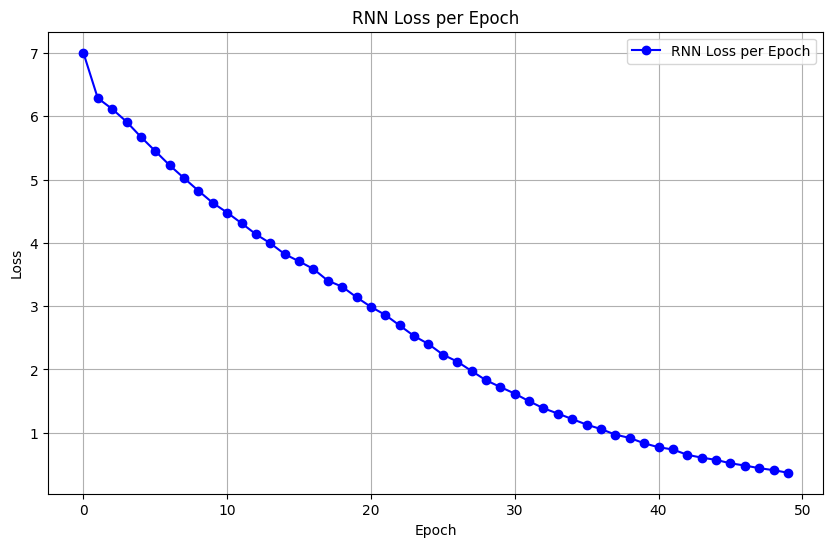

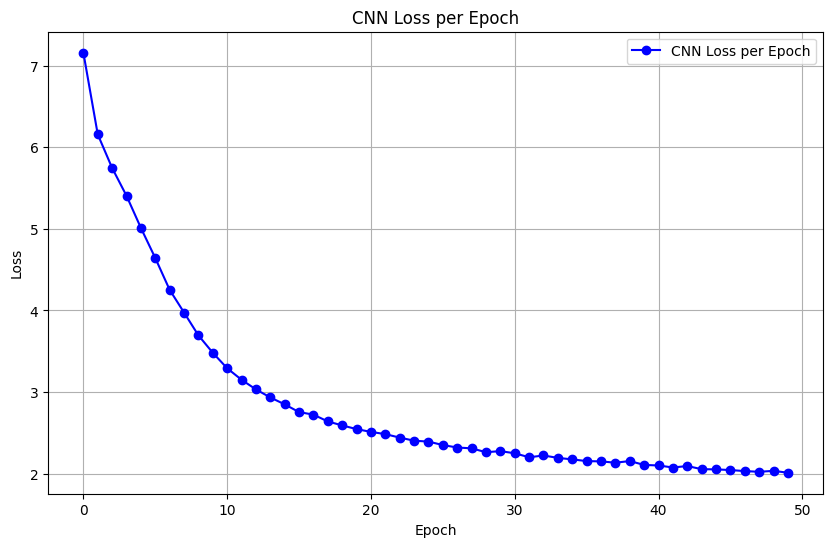

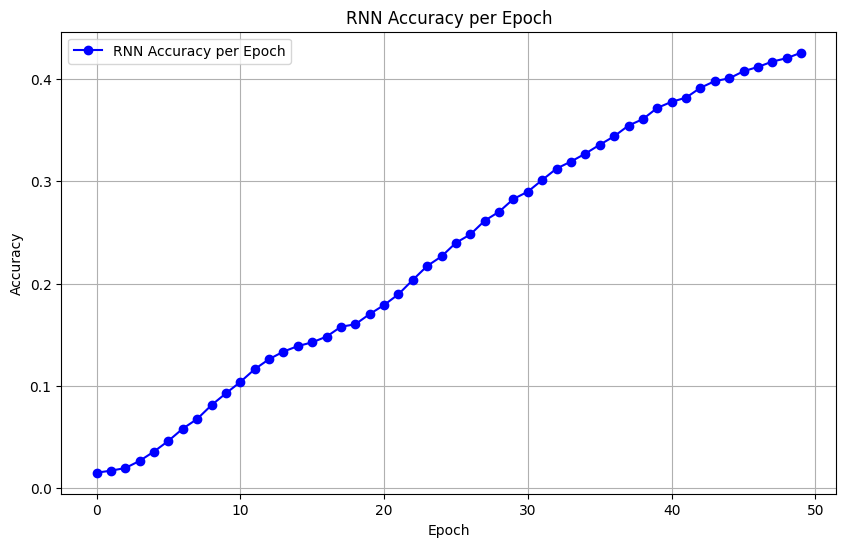

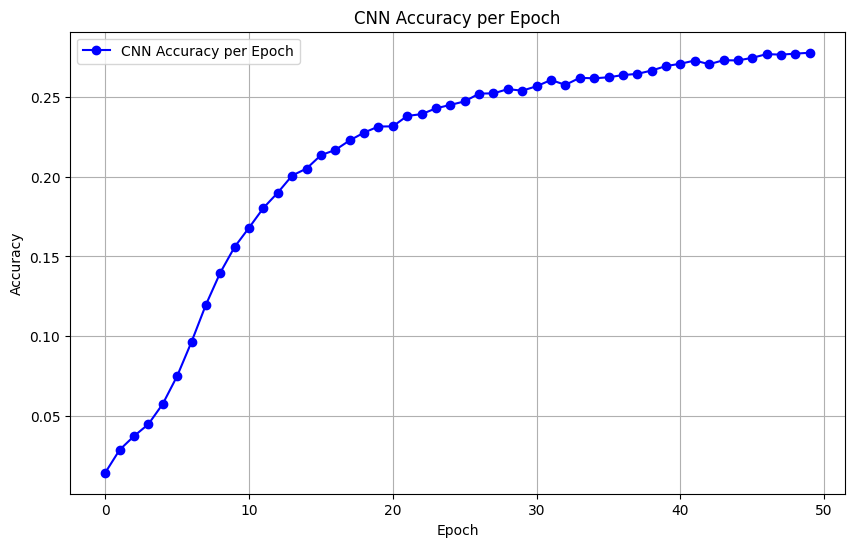

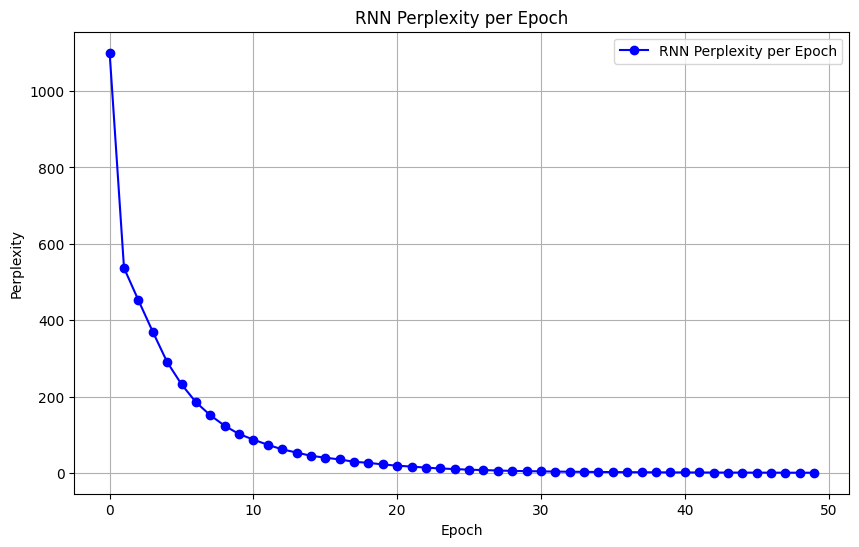

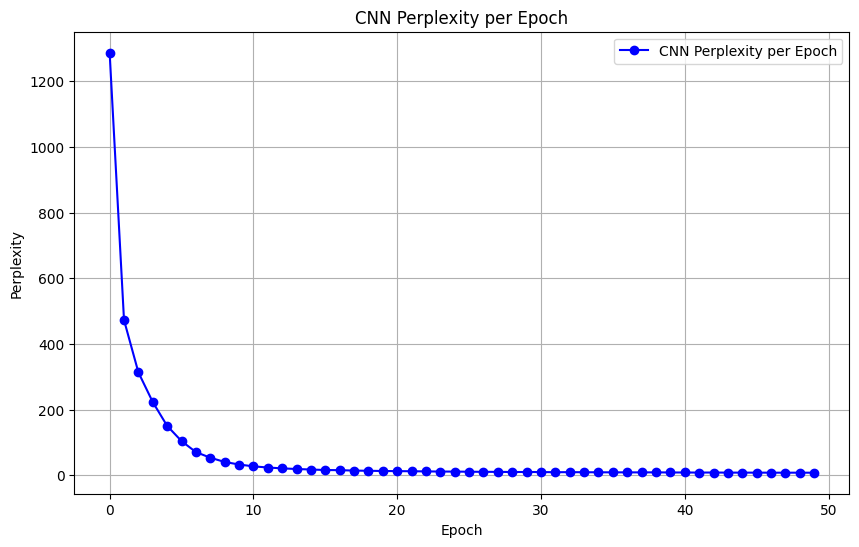

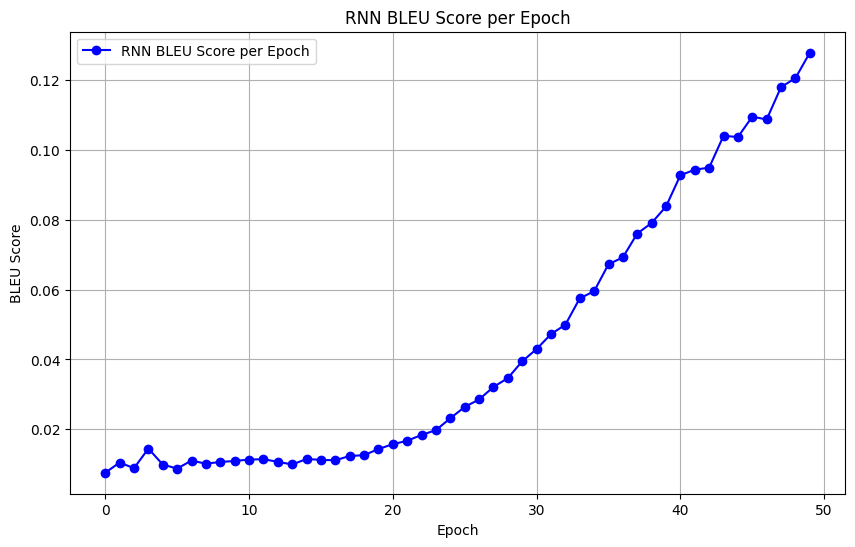

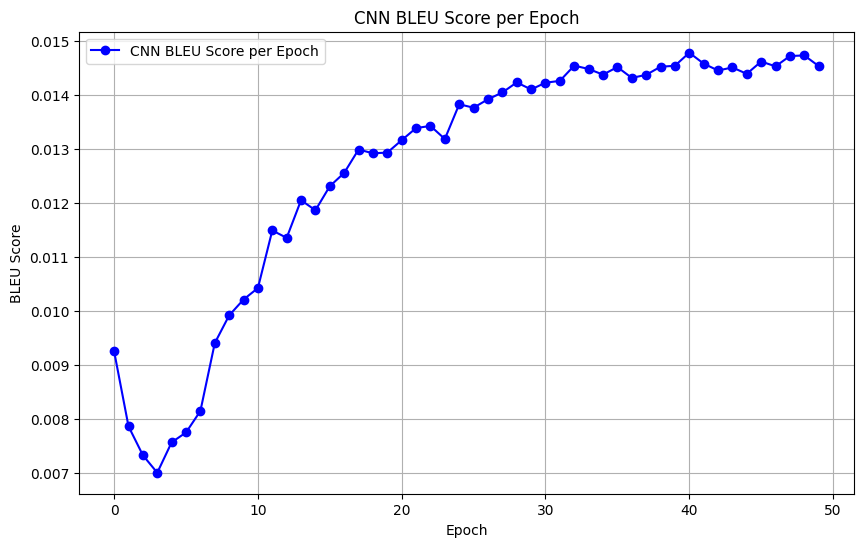

In [70]:
# Plot Results
plot_metric(metrics, "rnn_loss", "RNN Loss per Epoch", "Loss")
plot_metric(metrics, "cnn_loss", "CNN Loss per Epoch", "Loss")
plot_metric(metrics, "rnn_token_accuracy", "RNN Accuracy per Epoch", "Accuracy")
plot_metric(metrics, "cnn_token_accuracy", "CNN Accuracy per Epoch", "Accuracy")
plot_metric(metrics, "rnn_perplexity", "RNN Perplexity per Epoch", "Perplexity")
plot_metric(metrics, "cnn_perplexity", "CNN Perplexity per Epoch", "Perplexity")
plot_metric(metrics, "bleu_score_rnn", "RNN BLEU Score per Epoch", "BLEU Score")
plot_metric(metrics, "bleu_score_cnn", "CNN BLEU Score per Epoch", "BLEU Score")

In [153]:
def infer_with_both(input_text, rnn_encoder, rnn_decoder, cnn_encoder, cnn_decoder, word2idx, idx2word, intents, max_len=10):
    # Step 1: Fallback to intent-based patterns in intents.json
    for intent in intents["intents"]:
        for pattern in intent["patterns"]:
            if pattern.lower() in input_text.lower():
                return {
                    "RNN Response": np.random.choice(intent["responses"]),
                    "CNN Response": np.random.choice(intent["responses"]),
                }

    # Step 2: Convert input text to indices
    input_indices = [word2idx.get(word, word2idx["<UNK>"]) for word in input_text.split()]
    input_tensor = torch.tensor([input_indices]).to(device)

    # Step 3: Inference with RNN
    rnn_encoder.eval()
    rnn_decoder.eval()
    with torch.no_grad():
        rnn_enc_outputs, (hidden, cell) = rnn_encoder(input_tensor)
        rnn_response = generate_response(rnn_decoder, hidden, cell, rnn_enc_outputs, idx2word, max_len)

    # Step 4: Inference with CNN
    cnn_encoder.eval()
    cnn_decoder.eval()
    with torch.no_grad():
        cnn_enc_outputs = cnn_encoder(input_tensor)
        cnn_response = generate_response(cnn_decoder, None, None, cnn_enc_outputs, idx2word, max_len, is_rnn=False)

    # Final Step: Return responses
    return {
        "RNN Response": rnn_response,
        "CNN Response": cnn_response,
    }


def generate_response(decoder, hidden, cell, encoder_outputs, idx2word, max_len=10, is_rnn=True):
    decoder_input = torch.tensor([[word2idx['<SOS>']]]).to(device)  # Start with <SOS>
    output_sentence = []

    for step in range(max_len):
        if is_rnn:
            # RNN Decoder
            outputs, hidden, cell = decoder(decoder_input, hidden, cell, encoder_outputs)
        else:
            # CNN Decoder
            outputs = decoder(decoder_input, encoder_outputs)

        # Apply argmax to get the predicted word index
        prediction = outputs.argmax(dim=-1)  # Ensure argmax is applied on the vocab dimension

        # Extract next word index based on shape
        if prediction.dim() == 2:  # Shape: (batch_size, seq_len)
            next_word_idx = prediction[0, -1].item()
        elif prediction.dim() == 1:  # Shape: (batch_size)
            next_word_idx = prediction[0].item()
        else:
            raise ValueError(f"Unexpected prediction shape: {prediction.shape}")

        # Convert index to word
        next_word = idx2word[next_word_idx]

        # Break on <EOS>
        if next_word == '<EOS>':
            break

        # Append to output sentence and update decoder input
        output_sentence.append(next_word)
        decoder_input = prediction.unsqueeze(1)  # Ensure decoder input has shape (batch_size, 1)

    return ' '.join(output_sentence)


In [170]:
# Example User Input
user_input = "How are you?"

# Generate Responses
responses = infer_with_both(user_input, rnn_encoder, rnn_decoder, cnn_encoder, cnn_decoder, word2idx, idx2word, intents)
print(f"User: {user_input}")

# Print Responses
print(f"RNN Response: {responses['RNN Response']}")
print(f"CNN Response: {responses['CNN Response']}")


User: How are you?
RNN Response: Good to see you again!
CNN Response: Hi there, how can I help?
